<a href="https://colab.research.google.com/github/msof07/mahelioliv.github.io/blob/master/An%C3%A1lisis_de_Sentimiento_Encuestas_Ver_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notas para modificación

* ~~Remover el stemming para ver si mejora la calificación de la polaridad~~ (casi no hay diferencia en este caso, sample: 92)
* Cómo modificar elementos de polaridad que por contexto se entienden pero que problamente no lo sabe la herramienta
* Estos comentarios son los anotados por la escuela, el sentimiento puede ser diferente a los escritos por el mismo padre de familia, ver si hay diferencia
* ~~Cargar los scores en un nuevo dataframe~~
  * Sentiment by keyword
  * Top positive keywords
  * Top negative kewwords
  * ~~Sentiment share plot~~ *** fijarme en la suma por si hay valores negativos sino se van a restar
* Hacer en formato de función el key wordcloud y ~~la polaridad~~

## Librerías

In [1]:
import nltk
import re
import pandas as pd
import matplotlib.pyplot as plt

from wordcloud import WordCloud
from google.colab import drive
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Word sequence raltion
from collections import Counter
from nltk.util import ngrams

# For Sentiment Analysis
from nltk. sentiment.vader import SentimentIntensityAnalyzer
from nltk import sentiment
from nltk import word_tokenize

El SSL debe estar deshabilitado de otra manera un error 'certificate verify failed' seguirá apareciendo. Debe de abrir la ventana con las librerías del nltk y descargar las requeridas. En este caso se necesita el vader_lexicon que es obligatorio para usar SentimentIntensityAnalyzer. Aunque ya se descargaron por primera vez, como no está deshabilidado saldrá el pop up cada vez.

In [2]:
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download()

NLTK Downloader
---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> q


True

In [3]:
# Downloads

nltk.download('vader_lexicon')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

## Preprocesamiento

Para esta primera prueba, la data ha sido "limpiada" en sintaxis y errores gramaticales. De acuerdo con MS Office el editor indicaba una puntuación de 75%, después de las correcciones la puntuación es de 97%. La desventaja del NLPT es que no soporta el español, por lo que básicamente hay dos opciones:

1. Traducir el texto a inglés, sin embargo las ideas pueden cambiar durante este proceso entre otros problemas.
2. Usar "parches" con el cual se use el NLPT pero adapatado en el español sin embargo el soporte puede no estar adaptado completamente entre otros problemas en cuanto al código.

Tanto los errores ortográficos/sintaxis como la traducción pueden incluirse dentro del código a través de un API, como primera aproximación se alimentará con la data limpia de errores y traducida. Queda pendiente probar los parches disponibles para el español y adaptarlo al código además de automatizar la limpieza y traducción.

Aún con la data limpia, se deben realizar ciertos pasos antes para realizar el análisis:

* Tokenización, es decir, dividir el texto en frases
* Stemming, que es un método para reducir una palabra a su raíz o a un stem (ex. consult, consulting, consultant, etc)
* Lemmanization, hace el trabajo de relacionar las palabras con significados aproximados o que estén relacionadas (ex. good, better, etc)

Ambos ayudan a asignar varias palabras a una raíz común. De esa manera, estas palabras se tratan de manera similar y el modelo aprende que se pueden usar en contextos similares.

In [4]:
def preprocess(raw_text):
    
    # regex para identificar únicamente letras (en caso de que haya símbolos)
    # habría que ver si ciertos símbolos son importantes como por ejemplo ($)
    # en caso de que se hable de montos monetarios
    letters_only_text = re.sub("[^a-zA-Z]", " ", raw_text)

    # convierte en minúsculas and separa las palabras, ex. 'hello world' -> ['hello', 'world']
    words = letters_only_text.lower().split()

    cleaned_words = []
    lemmatizer = WordNetLemmatizer() # se puede agregar un stemmer, lemmatizer(? en particular
    
    # remover los stopwords
    stopWords = set(stopwords.words('english'))
    # hay stopwords disponibles en español o bien hacer un txt con los stopwords que quiera
    # REF: https://pythonspot.com/nltk-stop-words/
    for word in words:
        if word not in stopWords:
            cleaned_words.append(word)
    
    # stemm o lemmatise
    lem_words = []
    for word in cleaned_words:
        word = lemmatizer.lemmatize(word)   # es exactamente lo mismo para lemmatise pero con 'lemmatize' en vez de stem
        lem_words.append(word)
    
    # regresa la lista de strings
    return " ".join(lem_words)

In [5]:
test_sentence = "this is a sentence to demonstrate how the preprocessing function works...!"

preprocess(test_sentence)

'sentence demonstrate preprocessing function work'

## Load Data

In [7]:
# url ='https://github.com/msof07/rcsa_lab/blob/28989d50f3879835de97b0efe4bac81e9146fb71/comments_clean.xlsx'
# comments_df = pd.read_excel(url)

# github's raw link not working for private repositories i have to check how to concede permissions later

drive.mount("/content/gdrive")

comments_df = pd.read_excel('/content/gdrive/My Drive/Colab Notebooks/Datasets/Comentarios Colegios/com_queretaro.xlsx')

comments_df.head()

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


,Comentarios del Colegio,TRAD Comentarios del Colegio,Comentarios por familia,TRAD Comentarios por familia,Aspecto negativo durante su experiencia,TRAD Aspecto negativo,"Comentario, sugerencia o recomendación",TRAD Sugerencia,Aspectos positivos de su experiencia en el centro,TRAD Aspectos positivos,Qué podríamos hacer para que continuara,TRAD Continuidad
0,La familia hace traslado porque solo quiere cl...,The family makes transfer because he only want...,La familia notificó que se van al Kennedy por...,The family notified that they go to Kennedy be...,"No, ninguno.",None.,El comentario sería que estuve muy feliz por l...,The comment would be that I was very happy for...,"Los profesores están pendientes, y me encanta ...","The teachers are pending, and I love that they...",Financieramente nos imposibilita el hecho de q...,Financially we are unable to make the fact tha...
1,La familia no quiere tomar clases presenciales...,The family does not want,La familia hace traslado porque solo quiere cl...,The family makes transfer because he only want...,Ninguno,None,Ninguno,None,Nivel educativo completo,Complete educational level,"No depende del colegio, depende de la salud de...","It does not depend on school, it depends on my..."
2,No quiere clases en línea,He doesn't want online classes,Sonia Villarreal avisó que ya había hecho su p...,Sonia Villarreal warned that she had already d...,Ninguno,None,Estuvimos muy contentos este año,We were very happy this year,Buen nivel académico,Good academic level,"Nada, ya que nos vamos fuera del país","Nothing, since we are going out of the country"
3,La familia tiene varios pendientes administrat...,The family has several administrative earrings...,El motivo real de la baja que tomará clases en...,The real reason for the decline that will take...,Ninguno,None,Estuvimos muy contentos este año en el colegio,We were very happy this year at school,Nivel académico,Academic level,"Nada, ya que nos vamos al extranjero","Nothing, since we go abroad"
4,"La familia se va a la Cd. de México, se va a...","The family goes to Mexico City, goes to a scho...",La familia quiere educación Montessori,THE FAMILY WANTS MONTESORI EDUCATION,mas ingles,more English,no,no,muy padres instalaciones,Very parents facilities,nada,anything


In [9]:
comments_df['PREP Comentarios del Colegio'] = comments_df['TRAD Comentarios del Colegio'].dropna().apply(preprocess)
comments_df['PREP Comentarios por familia'] = comments_df['TRAD Comentarios por familia'].dropna().apply(preprocess)
comments_df['PREP Aspecto negativo durante su experiencia'] = comments_df['TRAD Aspecto negativo'].dropna().apply(preprocess)
comments_df['PREP Comentario, sugerencia o recomendación'] = comments_df['TRAD Sugerencia'].dropna().apply(preprocess)
comments_df['PREP Aspectos positivos de su experiencia en el centro'] = comments_df['TRAD Aspectos positivos'].dropna().apply(preprocess)
comments_df['PREP Qué podríamos hacer para que continuara'] = comments_df['TRAD Continuidad'].dropna().apply(preprocess)


comments_df.head()

,Comentarios del Colegio,TRAD Comentarios del Colegio,Comentarios por familia,TRAD Comentarios por familia,Aspecto negativo durante su experiencia,TRAD Aspecto negativo,"Comentario, sugerencia o recomendación",TRAD Sugerencia,Aspectos positivos de su experiencia en el centro,TRAD Aspectos positivos,Qué podríamos hacer para que continuara,TRAD Continuidad,PREP Comentarios del Colegio,PREP Comentarios por familia,PREP Aspecto negativo durante su experiencia,"PREP Comentario, sugerencia o recomendación",PREP Aspectos positivos de su experiencia en el centro,PREP Qué podríamos hacer para que continuara
0,La familia hace traslado porque solo quiere cl...,The family makes transfer because he only want...,La familia notificó que se van al Kennedy por...,The family notified that they go to Kennedy be...,"No, ninguno.",None.,El comentario sería que estuve muy feliz por l...,The comment would be that I was very happy for...,"Los profesores están pendientes, y me encanta ...","The teachers are pending, and I love that they...",Financieramente nos imposibilita el hecho de q...,Financially we are unable to make the fact tha...,family make transfer want class online due pan...,family notified go kennedy want ib,none,comment would happy teacher support mario warm...,teacher pending love located child could descr...,financially unable make fact achieved scholars...
1,La familia no quiere tomar clases presenciales...,The family does not want,La familia hace traslado porque solo quiere cl...,The family makes transfer because he only want...,Ninguno,None,Ninguno,None,Nivel educativo completo,Complete educational level,"No depende del colegio, depende de la salud de...","It does not depend on school, it depends on my...",family want,family make transfer want class online due pan...,none,none,complete educational level,depend school depends husband health
2,No quiere clases en línea,He doesn't want online classes,Sonia Villarreal avisó que ya había hecho su p...,Sonia Villarreal warned that she had already d...,Ninguno,None,Estuvimos muy contentos este año,We were very happy this year,Buen nivel académico,Good academic level,"Nada, ya que nos vamos fuera del país","Nothing, since we are going out of the country",want online class,sonia villarreal warned already done process s...,none,happy year,good academic level,nothing since going country
3,La familia tiene varios pendientes administrat...,The family has several administrative earrings...,El motivo real de la baja que tomará clases en...,The real reason for the decline that will take...,Ninguno,None,Estuvimos muy contentos este año en el colegio,We were very happy this year at school,Nivel académico,Academic level,"Nada, ya que nos vamos al extranjero","Nothing, since we go abroad",family several administrative earring already ...,real reason decline take class online since wa...,none,happy year school,academic level,nothing since go abroad
4,"La familia se va a la Cd. de México, se va a...","The family goes to Mexico City, goes to a scho...",La familia quiere educación Montessori,THE FAMILY WANTS MONTESORI EDUCATION,mas ingles,more English,no,no,muy padres instalaciones,Very parents facilities,nada,anything,family go mexico city go school close home wan...,family want montesori education,english,,parent facility,anything


## WordCloud

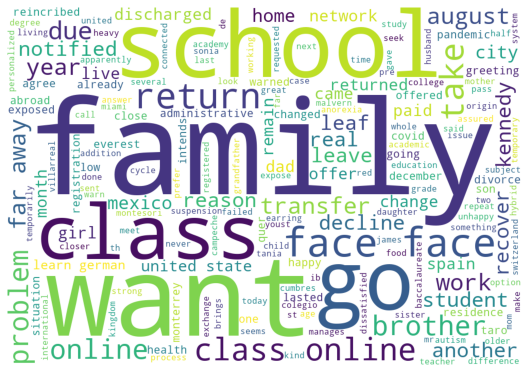

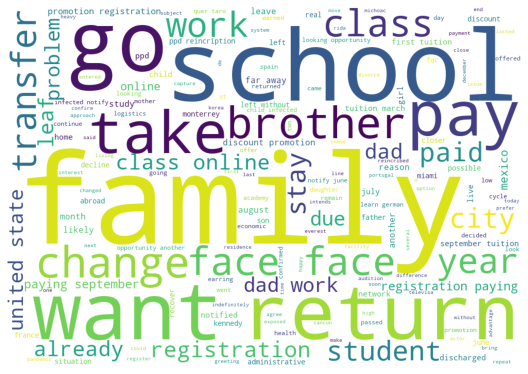

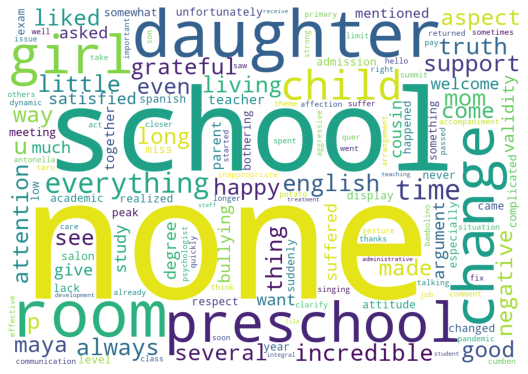

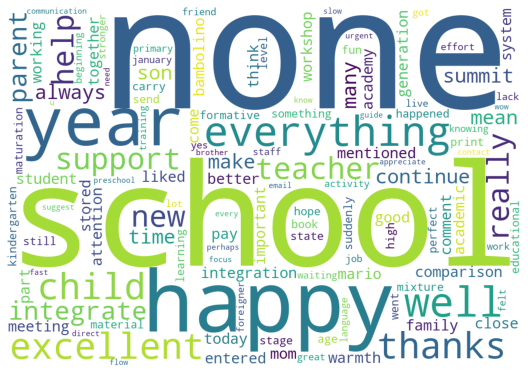

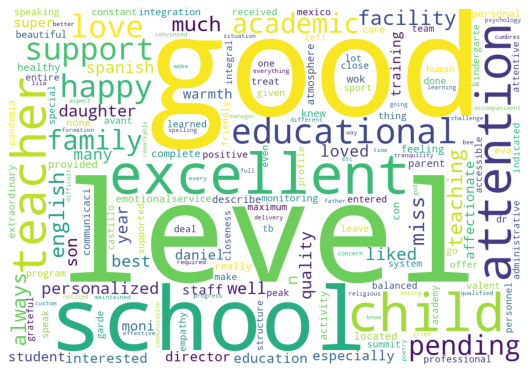

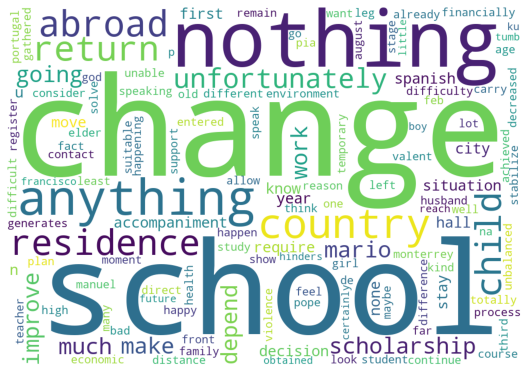

In [14]:
## CHECK THIS FUNC

def wordcloud_img(preped_df):
  all_words = '' 

  for arg in preped_df.dropna(): 

      tokens = arg.split()  
        
      all_words += " ".join(tokens)+" "

  wordcloud = WordCloud(width = 1000, height = 700, 
                  background_color ='white', 
                  min_font_size = 10).generate(all_words) 
    
  # WordCloud image plot               
  plt.figure(figsize = (10, 5), facecolor = None) 
  plt.imshow(wordcloud) 
  plt.axis("off") 
  plt.tight_layout(pad = 0) 
    
  return plt.show()

wordcloud_img(comments_df['PREP Comentarios del Colegio'])
wordcloud_img(comments_df['PREP Comentarios por familia'])
wordcloud_img(comments_df['PREP Aspecto negativo durante su experiencia'])
wordcloud_img(comments_df['PREP Comentario, sugerencia o recomendación'])
wordcloud_img(comments_df['PREP Aspectos positivos de su experiencia en el centro'])
wordcloud_img(comments_df['PREP Qué podríamos hacer para que continuara'])

#### Common Words

In [17]:
Counter(" ".join(comments_df['PREP Comentarios del Colegio'].dropna()).split()).most_common(10)

[('family', 33),
 ('face', 28),
 ('want', 23),
 ('class', 23),
 ('school', 21),
 ('go', 17),
 ('online', 16),
 ('return', 11),
 ('take', 9),
 ('brother', 7)]

In [18]:
Counter(" ".join(comments_df['PREP Comentarios por familia'].dropna()).split()).most_common(10)

[('family', 66),
 ('school', 38),
 ('face', 30),
 ('go', 27),
 ('registration', 25),
 ('want', 24),
 ('class', 23),
 ('return', 22),
 ('work', 20),
 ('pay', 20)]

In [19]:
Counter(" ".join(comments_df['PREP Aspecto negativo durante su experiencia'].dropna()).split()).most_common(10)

[('none', 15),
 ('school', 5),
 ('daughter', 4),
 ('room', 4),
 ('change', 3),
 ('preschool', 3),
 ('like', 3),
 ('girl', 3),
 ('child', 3),
 ('everything', 3)]

In [20]:
Counter(" ".join(comments_df['PREP Comentario, sugerencia o recomendación'].dropna()).split()).most_common(10)

[('none', 6),
 ('school', 5),
 ('would', 3),
 ('happy', 3),
 ('year', 3),
 ('everything', 3),
 ('well', 3),
 ('excellent', 3),
 ('since', 3),
 ('child', 3)]

In [21]:
Counter(" ".join(comments_df['PREP Aspectos positivos de su experiencia en el centro'].dropna()).split()).most_common(10)

[('level', 8),
 ('good', 8),
 ('school', 7),
 ('excellent', 7),
 ('child', 6),
 ('teacher', 5),
 ('attention', 5),
 ('educational', 5),
 ('love', 4),
 ('support', 4)]

In [26]:
# N-GRAMS PARA PARES DE PALABRAS

all_words = '' 

for arg in comments_df['PREP Aspecto negativo durante su experiencia'].dropna(): 
  
  tokens = arg.split()  
  
  all_words += " ".join(tokens)+" "

n_gram = 2
n_gram_dic = dict(Counter(ngrams(all_words.split(), n_gram)))

for i in n_gram_dic:
    if n_gram_dic[i] >= 2:
        print(i, n_gram_dic[i])

('none', 'none') 5
('preschool', 'incredible') 2
('none', 'negative') 2
('negative', 'aspect') 2
('living', 'room') 2
('school', 'none') 2
('long', 'time') 2


## Análisis de polaridad

* neg (negativa)
* neu (neutral)
* pos (positiva)

compound: valor entre -1 y 1 indica si la frase es positiva o negativa. Valores próximos a -1 indican que es muy negativa, próximos a cero indicarían que es neutra y próximos a 1 sería muy positiva.

In [33]:
sind = SentimentIntensityAnalyzer()

def polarity_comment(col_prep):

  negative = []
  neutral = []
  positive = []
  compound_score = []

  comments_scored = pd.DataFrame()

  for comments in col_prep:
      scores = sind.polarity_scores(comments)
      for key in scores:
        if key == 'neg':
          negative.append(list(scores.values())[0])
        elif key == 'neu':
          neutral.append(list(scores.values())[1])
        elif key == 'pos':
          positive.append(list(scores.values())[2])
        elif key == 'compound':
          compound_score.append(list(scores.values())[3])

  comments_scored = comments_scored.assign(neg_score=negative, neu_score=neutral, pos_score=positive, compound=compound_score)
  return comments_scored

In [ ]:
columnas = (comments_df['PREP Comentarios del Colegio'], comments_df['PREP Comentarios por familia'], comments_df['PREP Aspecto negativo durante su experiencia'], 
            comments_df['PREP Comentario, sugerencia o recomendación'], comments_df['PREP Aspectos positivos de su experiencia en el centro'], 
            comments_df['PREP Qué podríamos hacer para que continuara'])

In [37]:
sentiment_df = polarity_comment(comments_df['PREP Aspecto negativo durante su experiencia'].dropna())
sentiment_df.head()

,neg_score,neu_score,pos_score,compound
0,0.0,1.0,0.0,0.0
1,0.0,1.0,0.0,0.0
2,0.0,1.0,0.0,0.0
3,0.0,1.0,0.0,0.0
4,0.0,1.0,0.0,0.0


In [39]:
sentiment_df.describe()

,neg_score,neu_score,pos_score,compound
count,42.000000,42.000000,42.000000,42.000000
mean,0.086048,0.587286,0.112429,0.057900
std,0.206345,0.405126,0.221187,0.333536
min,0.000000,0.000000,0.000000,-0.862500
25%,0.000000,0.213000,0.000000,0.000000
50%,0.000000,0.637000,0.000000,0.000000
75%,0.000000,1.000000,0.113250,0.000000
max,0.787000,1.000000,0.836000,0.956500


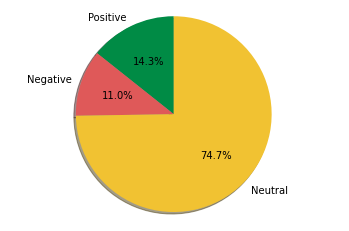

In [38]:
sum_neg = sentiment_df['neg_score'].sum()
sum_pos = sentiment_df['pos_score'].sum()
sum_neu = sentiment_df['neu_score'].sum()

labels = 'Positive', 'Negative', 'Neutral'
sizes = [sum_pos, sum_neg, sum_neu]

colors = ['#008b45','#df5959','#f1c232']

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90, colors=colors)
ax1.axis('equal')  # aspect ratio circle.

plt.show()

## Topic Modeling

En proceso...

## De diccionario a matriz a dataframe (IGNORAR)

`polarity_scores` method devuelve los valores en forma de diccionario, debo convertirlo a una lista por cada comentario para poder agregarlo al dataframe principal

In [ ]:
for comments in comments_df['prep'][0:3]:
  scores = sind.polarity_scores(comments)
  print(comments)
  print(scores)
  for element in scores.values():
    print(element)
  #for key in scores:
    #print(key, ":", scores [key])
    #print()

In [ ]:
temp_neg = []
temp_neu = []
temp_pos = []
temp_comp = []

for comments in comments_df['prep']:
  scores = sind.polarity_scores(comments)
  for key in scores:
    if key == 'neg':
      temp_neg.append(list(scores.values())[0])
    elif key == 'neu':
      temp_neu.append(list(scores.values())[1])
    elif key == 'pos':
      temp_pos.append(list(scores.values())[2])
    elif key == 'compound':
      temp_comp.append(list(scores.values())[3])

# devuelve una lista con los scores de cada comentario
# ie. una matriz de 4 x len(comments_df)
print(temp_neg)